## NYC 311 Data

Analysis3:
- From Analysis 2 we could derive that HEAT/HOT WATER is the highest reported incident. In this analysis we will try to dig further and find the average resolution time for this issue by each Borough for Years 2015, 2016 and 2017. 
- Create a WordCloud from the Resolution_Description Corpus of the data.

In [11]:
import os
import pandas as pd
import numpy as np
import datetime
%matplotlib inline

from matplotlib import pyplot as plt
# datetime.datetime.strptime
import glob

try:
    os.chdir('C:/Users/Dhaval/Python_Data/bhinde_dhaval_spring2017/') # making changes to cwd for local reference
except:
    pass


In [12]:
path ="Finals\\Data\\"
file_list =glob.glob(os.path.join(path,"*.csv"))
np_array_list =[]

for file in file_list:
    print("Starting with"+file)
    df=pd.read_csv(file,usecols=['created_date','closed_date','complaint_type','borough','resolution_description'], \
                   encoding='latin-1',low_memory=False)
    np_array_list.append(df.as_matrix())
    
comb_np_array = np.vstack(np_array_list)
df = pd.DataFrame(comb_np_array)
df.columns=['Borough','Closed_Date','Complaint_Type','Created_Date','Resolution']


Starting withFinals\Data\311_2015.csv
Starting withFinals\Data\311_2016.csv
Starting withFinals\Data\311_2017.csv


From Analysis 2 we figured that HEAT/HOT WATER is one of the most prominent issue reported. 
In this analysis we will figure the response time for this issue by Borough. 
Also, heat issue are valid in Winters and Early Spring which Includes months (Oct-May)

In [8]:
# Filter data by HEAT and transform JSON date to datetime

data = df.loc[(df['Complaint_Type'] == 'HEATING') | (df['Complaint_Type'] == 'HEAT/HOT WATER') ]
heatmonths = [1,2,3,4,5,10,11,12]
pd.options.mode.chained_assignment = None  # default='warn'

data['Created_Date'] =  pd.to_datetime(data['Created_Date'].astype('str') , format='%Y-%m-%dT%H:%M:%S.%f')
data['Closed_Date'] =  pd.to_datetime(data['Closed_Date'].astype('str') , format='%Y-%m-%dT%H:%M:%S.%f')

In [9]:
# Extract Data which includes months of Winter and Early Spring

createdmask = data['Created_Date'].map(lambda x: (x.month in heatmonths))
closedmask = data['Closed_Date'].map(lambda x: (x.month in heatmonths) if x != None else False)

mask = createdmask & closedmask
heatseasondata = data.loc[mask]


Compare the number of heat/hot water complaints created and closed inside VS outside of heating season.

In [10]:
print("No. of requests Inside the Season:",len(data.loc[mask]))  #inside heating season
print("No. of requests Outside the Season:",len(data.loc[~mask])) #outside heating season

No. of requests Inside the Season: 521895
No. of requests Outside the Season: 23661


The next thing we want to do is ignore cases where the complaint was resolved in the next heating season:

In [11]:
prevmonths = range(1, 6) 
nextmonths = [10,11,12]
heatseasondata['createdheatseason'] = [x.year if (x.month in prevmonths) else (x.year-1) for x in heatseasondata['Created_Date']]
heatseasondata['closedheatseason'] = [x.year if (x.month in prevmonths) else (x.year-1) for x in heatseasondata['Closed_Date']]

Now, we can select only the cases where the closed date was in the same season as the created date:
And, Calculate Average Resolution Times:

In [12]:
heatseasondata = heatseasondata.loc[heatseasondata['createdheatseason']  == heatseasondata['closedheatseason']]
heatseasondata['resolutiontime'] = heatseasondata['Closed_Date'] - heatseasondata['Created_Date']
heatseasondata['resolutiontimeint'] = heatseasondata.resolutiontime.astype('timedelta64[D]')
resolutiontimedata = heatseasondata.groupby(by='createdheatseason').mean()['resolutiontimeint']
resolutiontimedata

createdheatseason
2014    2.554468
2015    3.132296
2016    2.787158
2017    2.040874
Name: resolutiontimeint, dtype: float64

In [13]:
# Find the Average resolution time and segregate the data by Year

restimebyboro = heatseasondata.groupby(by=['Borough', 'createdheatseason']).mean()['resolutiontimeint']
restimebyboro = restimebyboro.reset_index() 
restimebyboro.columns=['Borough','Year','Resolution_Time']
restimebyboro14 = restimebyboro.loc[restimebyboro['Year'] == 2014]
restimebyboro15 = restimebyboro.loc[restimebyboro['Year'] == 2015]
restimebyboro16 = restimebyboro.loc[restimebyboro['Year'] == 2016]
restimebyboro17 = restimebyboro.loc[restimebyboro['Year'] == 2017]


In [14]:
# Plot the Average Resolution Time by Borough for Years 2014-2017 for HEAT issue.

from plotly import __version__
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf

plotly.offline.init_notebook_mode() 

plotly.offline.iplot({
"data": [
    plotly.graph_objs.Bar(x=restimebyboro14['Borough'],y=restimebyboro14['Resolution_Time'],name='2014'),        
    plotly.graph_objs.Bar(x=restimebyboro15['Borough'],y=restimebyboro15['Resolution_Time'],name='2015'),
    plotly.graph_objs.Bar(x=restimebyboro16['Borough'],y=restimebyboro16['Resolution_Time'],name='2016'),
    plotly.graph_objs.Bar(x=restimebyboro17['Borough'],y=restimebyboro17['Resolution_Time'],name='2017'),        
],
    'layout': {'title': 'Heating Issue - Average Resolution Time By Borough ',
    'xaxis': {'title': 'City'},
    'yaxis': {'title': 'Average Resolution Time (In Days)'}} 
})

In [13]:
# Creating a WordCloud by picking up the text from the resolution column of the dataframe

words = df['Resolution'].tolist()

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re
regex = re.compile("[^a-zA-Z\s.]")

snippet_clean = []

try:
    for i in range(len(words)):
        snippet_clean.append(regex.sub('', words[i]))  # Regex to clean the corpus 
except:
    pass
    
# Import stop words and lemmatize the corpus 
    
stop_words = set(stopwords.words("english"))
fin_snippet = ''.join(snippet_clean)

tokens = nltk.word_tokenize(fin_snippet)
wnl = nltk.WordNetLemmatizer()
lem_snippet = [wnl.lemmatize(t) for t in tokens]

lem_snippet_clean2 = [x for x in lem_snippet if x]
filtered_snippet = [w for w in lem_snippet_clean2 if not w.lower() in stop_words]  # Filter out the stop words

In [29]:
# Clean the tokens and convert list to string 

clean_tokens = []

for word in filtered_snippet:
    word = word.lower()
    if word.isalpha(): # drop all non-words
        clean_tokens.append(word)
        
str1 = ' '.join(clean_tokens) 


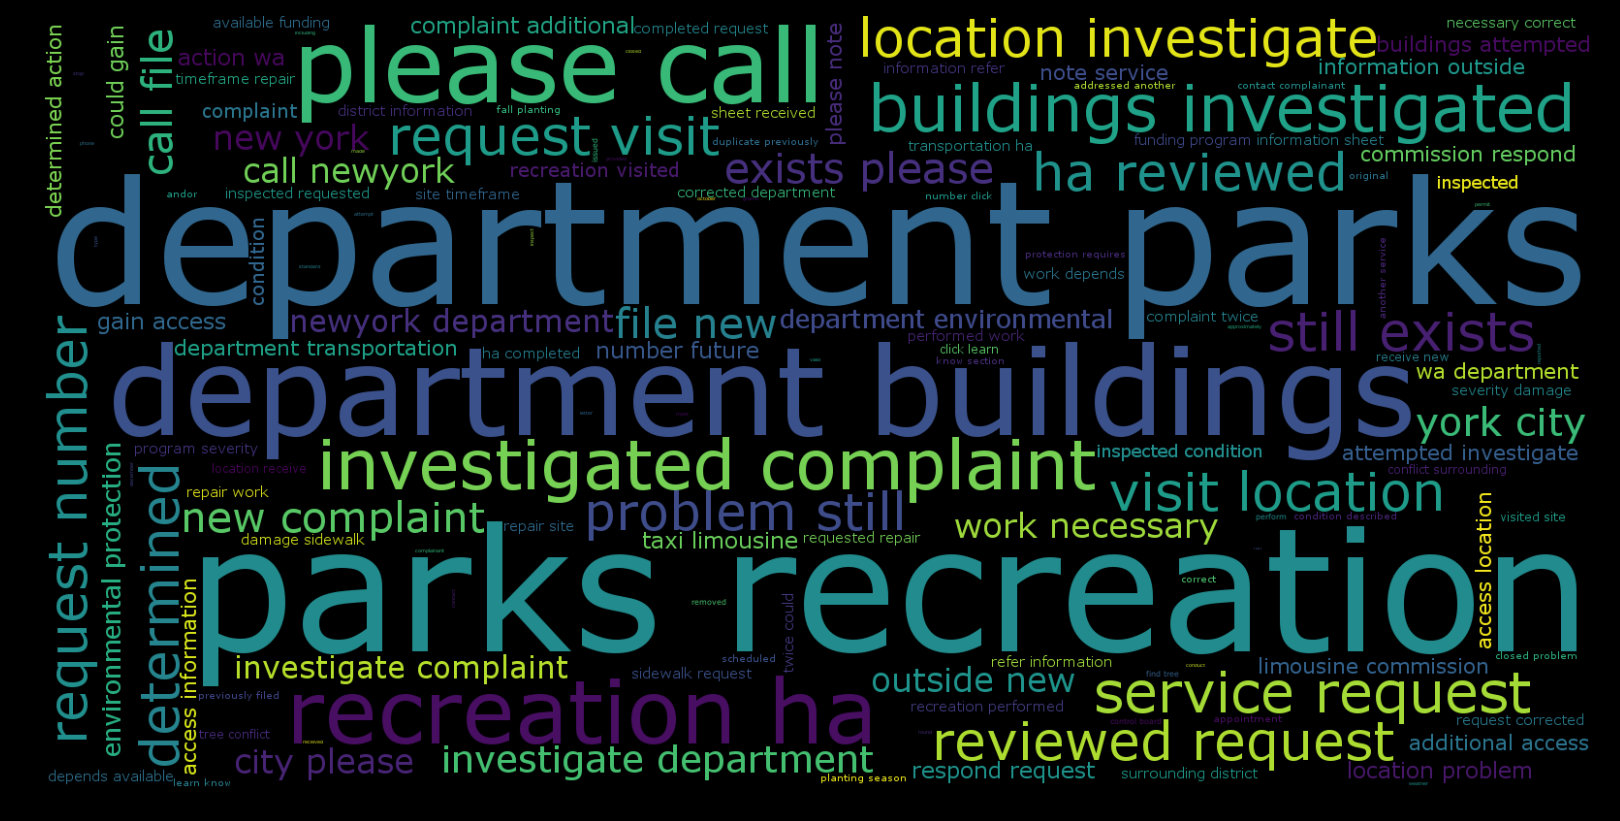

In [43]:
# Create a Word Cloud from the Corpus

from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import random

from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width=1600, height=800,
                      font_path='/Windows/Fonts/Verdana.ttf',
                      relative_scaling = 1.0,
                      stopwords = 'to of ha'
                      ).generate(str1)

plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('Finals\\Images\\wordcloud.png', facecolor='k', bbox_inches='tight')